In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import glob
import os

In [2]:
data_dir = str(os.getcwd()) + '/data/faces/'

In [227]:
training_images = data_dir+'training/'

(112, 92)


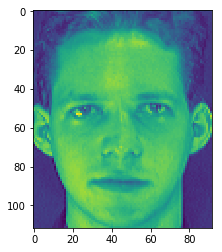

In [225]:
# checking out how an image looks
img = plt.imread(training_images+'s1/1.pgm')
print(np.shape(img))
plt.imshow(img)

In [89]:
def resize_img(img):
    return cv2.resize(img,(105,105))

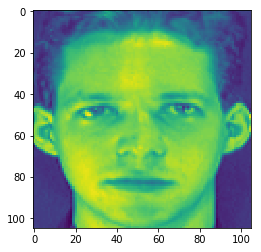

In [226]:
plt.imshow(resize_img(img))

In [91]:
training_images = glob.glob(os.getcwd()+'/data'+'/faces/training/'+'*')

In [92]:
np.shape(training_images)

(37,)

In [93]:
images = []
imgs = []
for i in (training_images):
    img_ = []
    for j in range(10):
        img = plt.imread(i+'/'+str(j+1)+'.pgm')
        img = resize_img(img)
        img_.append(img)
    imgs.append(img_)
        


In [94]:
np.shape(imgs
        )

(37, 10, 105, 105)

In [95]:
images_for_training = []
labels = []
### creating folder of the same images where label is 1
for i in range(np.shape(imgs)[0]):
    for j in range(np.shape(imgs)[1]-1):
        img_concatenated = []
        img_concatenated.append(imgs[i][j])
        img_concatenated.append(imgs[i][j+1])
        images_for_training.append(img_concatenated)
        labels.append(1)
        

    

In [96]:
np.shape(images_for_training)

(333, 2, 105, 105)

In [97]:
imgs_for_train = []
labels_train = []
for i in range(np.shape(imgs)[1]): #10
    for j in range(np.shape(imgs)[0]-1): #37
        imgs_concatenated = []
        imgs_concatenated.append(imgs[j][i])
        imgs_concatenated.append(imgs[j+1][i])
        imgs_for_train.append(imgs_concatenated)
        labels_train.append(0)
        

In [98]:
np.shape(imgs_for_train)

(360, 2, 105, 105)

In [99]:
x = np.concatenate([images_for_training, imgs_for_train])

In [100]:
np.shape(x)

(693, 2, 105, 105)

In [101]:
y = np.concatenate([labels, labels_train])

In [102]:
np.shape(y)

(693,)

In [103]:
from sklearn.model_selection import train_test_split

In [174]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [175]:
from docutils.nodes import image
from keras.layers import Conv2D, BatchNormalization, Dropout, Dense, Activation, Input, MaxPooling2D, Flatten, Lambda
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras import backend as K
import numpy as np


In [176]:
class Siamese_Net:
    def __init__(self, image1, image2):
        self.image1 = image1
        self.image2 = image2
        
   
    def net(self):
        
        x = Conv2D(64, 10, strides=1)(self.image1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        y = Conv2D(64, 10, strides=1)(self.image2)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        
        x = MaxPooling2D((2,2))(x)
        y = MaxPooling2D((2,2))(y)
        
        x = Conv2D(128, 7, strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        y = Conv2D(128, 7, strides=1)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        
        x = MaxPooling2D((2,2))(x)
        y = MaxPooling2D((2,2))(y)

        x = (Conv2D(128, 4, strides=1))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        y = (Conv2D(128, 4, strides=1))(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
                   
        x = MaxPooling2D((2,2))(x)
        y = MaxPooling2D((2,2))(y)
        
        x = (Conv2D(256, 4, strides=1))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        y = (Conv2D(256, 4, strides=1))(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)

        x = Flatten()(x)
        y = Flatten()(y)

        x = Dense(512, activation='sigmoid')(x)  # need to use 4096
        y = Dense(512, activation='sigmoid')(y)  # need to use 4096
        
        l1_distance_layer = Lambda(
            lambda tensors: K.abs((tensors[0] - tensors[1])))

        l1_distance = l1_distance_layer([x, y])
        
       
        prediction = Dense(1, activation='sigmoid')(l1_distance)
        
        return prediction
    
    def forward(self):
        output = self.net()
        model = Model([self.image1, self.image2], output)
        model.summary()
        return model

In [177]:
img_temp1_size = Input(shape=(105,105,1))
img_temp2_size = Input(shape=(105,105,1))


In [179]:
obj = Siamese_Net(img_temp1_size, img_temp2_size)

In [180]:
model = obj.forward()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 96, 96, 64)   6464        input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 96, 96, 64)   6464        input_24[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [181]:
adam = Adam(lr=0.001)
# sgd = SGD(lr = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

In [182]:
x_img_1 = x_train[:,0]
x_img_2 = x_train[:,1]


In [183]:
x_img_1 = np.reshape(x_img_1,(np.shape(x_img_1)[0],np.shape(x_img_1)[1],np.shape(x_img_1)[2],1))
x_img_2 = np.reshape(x_img_2,(np.shape(x_img_2)[0],np.shape(x_img_2)[1],np.shape(x_img_2)[2],1))

In [184]:
np.shape(x_img_1)

(623, 105, 105, 1)

In [185]:
model.fit([x_img_1, x_img_2], y_train, epochs=20, batch_size=16,validation_split=0.1, shuffle=True)
          #steps_per_epoch=100, validation_steps=5)

Train on 560 samples, validate on 63 samples
Epoch 1/20
560/560 [==============================] - 167s 298ms/step - loss: 0.6112 - acc: 0.6929 - val_loss: 0.6833 - val_acc: 0.6190
Epoch 2/20
560/560 [==============================] - 153s 272ms/step - loss: 0.4251 - acc: 0.8161 - val_loss: 0.7617 - val_acc: 0.5079
Epoch 3/20
560/560 [==============================] - 152s 272ms/step - loss: 0.3745 - acc: 0.8536 - val_loss: 0.7878 - val_acc: 0.4921
Epoch 4/20
560/560 [==============================] - 150s 267ms/step - loss: 0.3579 - acc: 0.8518 - val_loss: 0.8201 - val_acc: 0.4921
Epoch 5/20
560/560 [==============================] - 151s 270ms/step - loss: 0.2868 - acc: 0.9000 - val_loss: 0.8481 - val_acc: 0.5079
Epoch 6/20
560/560 [==============================] - 158s 283ms/step - loss: 0.2634 - acc: 0.9018 - val_loss: 0.6188 - val_acc: 0.6508
Epoch 7/20
560/560 [==============================] - 156s 279ms/step - loss: 0.2348 - acc: 0.9161 - val_loss: 0.5507 - val_acc: 0.6825
Epo

In [209]:
x_test_convert = np.reshape(x_test, [np.shape(x_test)[0], np.shape(x_test)[1], 
                                     np.shape(x_test)[2],np.shape(x_test)[3],1])
y_pred = model.predict([x_test_convert[:,0], x_test_convert[:,1]])

In [215]:
sum_ = 0
for i in range(len(y_pred)):
    if y_pred[i] > 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
    if(y_pred[i] == y_test[i]):
        sum_+=1

print(sum_/len(y_pred))

0.9571428571428572


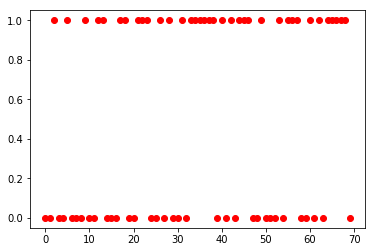

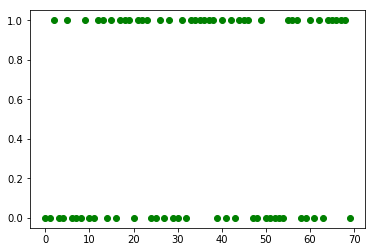

In [222]:
plt.plot(y_pred, 'or')
plt.subplots()
plt.plot(y_test, 'og')
plt.show()

1 [1.]


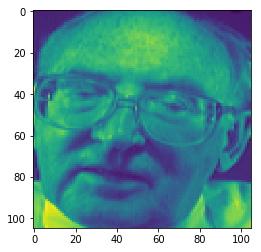

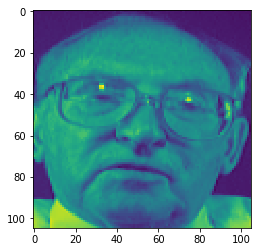

In [220]:
num_test = 2

print(y_test[num_test], y_pred[num_test])#checking if original and predicted labels are the same for the images

#displaying the images to check if they belonged to the same person
plt.imshow(x_test[:,0][num_test])
plt.subplots()
plt.imshow(x_test[:,1][num_test])